# Reduce size of Northern Ireland Small Areas (SA)

The file size of the Small Areas shapes is too large for sharing on GitHub and will make the `stroke-maps` package unnecessarily large. This notebook shows the process for reducing the file size.

## Method

The full SA file is over 100MB and contains ~8000 polygons. It is given on the 50K grid.

The matching England and Wales LSOA file is ~30MB and contains over 30,000 polygons. It is "Super Generalised Clipped", defined by the Office for National Statistics Open Geography portal as "Generalised to 200m and clipped to the coastline (Mean High Water mark)".

We will make the SA file match the LSOA file as closely as possible.

The bigger drop in file size is due to reducing the number of coordinates in the file, rather than keeping the same number of points to a lower precision.

## Notebook setup

In [ ]:
import pandas as pd
import geopandas as gpd
import os

import matplotlib.pyplot as plt

import shapely

import shapely.wkt

In [73]:
dir_geojson = '../data_geojson/ons_data'

In [74]:
file_sa_input = os.path.join(dir_geojson, 'sa2011.json')

In [75]:
gdf_sa = gpd.read_file(file_sa_input)

In [76]:
gdf_sa.head(3)

,OBJECTID,SA2011,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,Code_all,geometry
0,1,N00000002,95AA01S2,315465,377176,169.044,8476.858446,1.690436e+06,N00000002,"POLYGON ((315481.12500 376464.21880, 315472.34..."
1,2,N00000004,95AA01S2,307147,376182,8700.040,46727.719482,8.700042e+07,N00000004,"POLYGON ((307740.81250 382573.21880, 307762.25..."
2,3,N00000007,95AA01S3,314461,383440,1287.990,21817.292006,1.287995e+07,N00000007,"POLYGON ((311363.31250 385217.62500, 311600.00..."


In [77]:
crs = gdf_sa.crs

The Irish Grid coordinates are given in metres.


## Failed test 1: round coordinates

Round all points to the nearest 200 metres.

The `rounding_precision` can only round to so many decimal places, not rounding to the nearest ten or nearest hundred. So first transform the geometry coordinates by dividing them all by 200. This means that those transformed points are rounded to 0 decimal places, it's the same as rounding the original points to the nearest 200. Undoing the original transform then puts the coordinates back on the same scale as the start.

In [96]:
round_to_nearest_x_metres = 200

g_div = shapely.transform(gdf_sa['geometry'], lambda x: x / round_to_nearest_x_metres)
g_round = shapely.wkt.loads(shapely.wkt.dumps(g_div, rounding_precision=0))
g_mul = shapely.transform(g_round, lambda x: x * round_to_nearest_x_metres)

gdf_sa['geometry_round'] = g_mul

Check the results to see that this worked:

In [97]:
gdf_sa.head()

,OBJECTID,SA2011,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,Code_all,geometry,geometry_round
0,1,N00000002,95AA01S2,315465,377176,169.044,8476.858446,1.690436e+06,N00000002,"POLYGON ((315481.12500 376464.21880, 315472.34...","POLYGON ((315400 376400, 315400 376400, 315400..."
1,2,N00000004,95AA01S2,307147,376182,8700.040,46727.719482,8.700042e+07,N00000004,"POLYGON ((307740.81250 382573.21880, 307762.25...","POLYGON ((307800 382600, 307800 382400, 307800..."
2,3,N00000007,95AA01S3,314461,383440,1287.990,21817.292006,1.287995e+07,N00000007,"POLYGON ((311363.31250 385217.62500, 311600.00...","POLYGON ((311400 385200, 311600 385200, 312800..."
3,4,N00000008,95AA01S3,317009,383798,343.431,13536.640411,3.434310e+06,N00000008,"POLYGON ((317103.21880 385406.96880, 317102.18...","POLYGON ((317200 385400, 317200 385400, 317200..."
4,5,N00000009,95AA01S3,318697,383198,854.499,18169.764506,8.544992e+06,N00000009,"POLYGON ((317452.75000 385419.34380, 317458.68...","POLYGON ((317400 385400, 317400 385400, 317400..."


Plot some of the individual Small Area shapes.

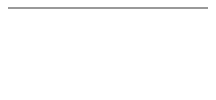

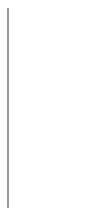

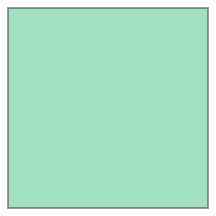

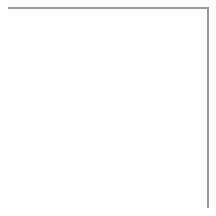

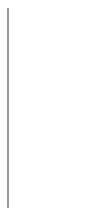

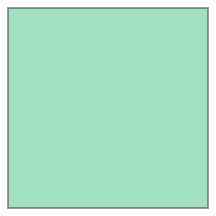

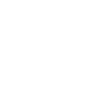

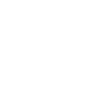

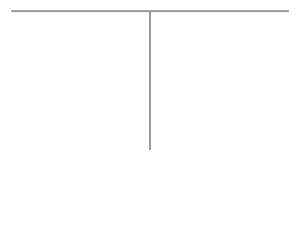

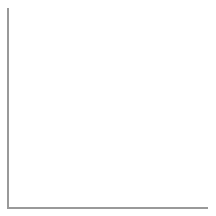

In [98]:
for i in range(10):
    display(gdf_sa.set_geometry('geometry_round').set_crs(crs, allow_override=True).sort_values('Shape_Area').geometry.iloc[i])

Already we can see that this will cause problems. A lot of the shapes are not much bigger than 200m square and so the reduced-precision geometries have zero area and non-zero perimeter.

Redo the rounding to the nearest 100m instead:

In [100]:
round_to_nearest_x_metres = 100

g_div = shapely.transform(gdf_sa['geometry'], lambda x: x / round_to_nearest_x_metres)
g_round = shapely.wkt.loads(shapely.wkt.dumps(g_div, rounding_precision=0))
g_mul = shapely.transform(g_round, lambda x: x * round_to_nearest_x_metres)

gdf_sa['geometry_round'] = g_mul

Plot the old and new geometries for comparison:

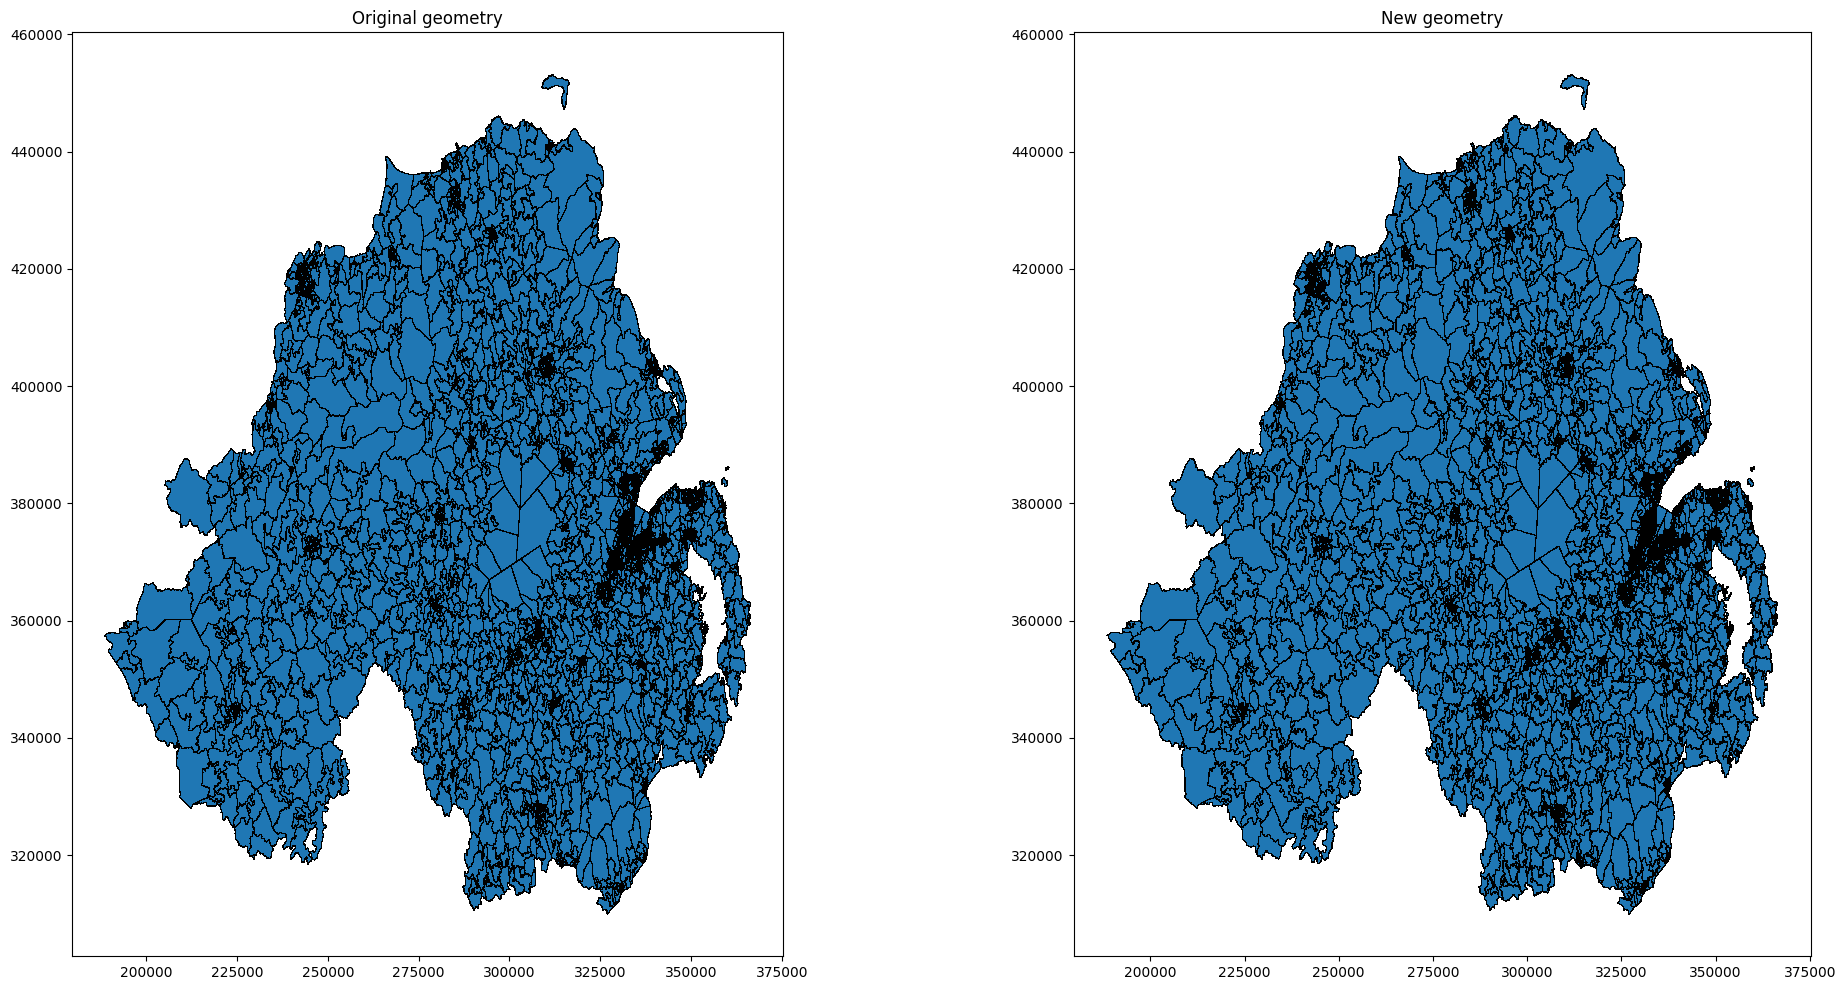

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

gdf_sa.plot(ax=axs[0], antialiased=False, edgecolor='k', linewidth=0.1)

gdf = gdf_sa.set_geometry('geometry_round').set_crs(crs, allow_override=True)
gdf.plot(ax=axs[1], antialiased=False, edgecolor='k', linewidth=0.1)

axs[0].set_title('Original geometry')
axs[1].set_title('New geometry')

plt.savefig('test1.png')
plt.show()

In [112]:
# Save to file:
gdf = gdf_sa.drop('geometry', axis='columns')
gdf = gdf.rename(columns={'geometry_round': 'geometry'})
gdf = gdf.set_geometry('geometry').set_crs(crs, allow_override=True)

gdf.to_file(f'sa2011_100m.geojson')

This method has not worked. The saved reduced geojson is still over 100MB in size (though the total size has reduced from the original).

Remove the new geometry from the starting data:

In [ ]:
gdf_sa = gdf_sa.drop('geometry_round', axis='columns')

## Failed test 2: grid size

Use a new grid of size 200 metres.

In [113]:
gdf_sa['geometry_round'] = shapely.set_precision(gdf_sa.geometry, grid_size=200)

In [114]:
gdf_sa.head()

,OBJECTID,SA2011,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,Code_all,geometry,geometry_round
0,1,N00000002,95AA01S2,315465,377176,169.044,8476.858446,1.690436e+06,N00000002,"POLYGON ((315481.12500 376464.21880, 315472.34...","MULTIPOLYGON (((315400.000 376600.000, 315200...."
1,2,N00000004,95AA01S2,307147,376182,8700.040,46727.719482,8.700042e+07,N00000004,"POLYGON ((307740.81250 382573.21880, 307762.25...","POLYGON ((307800.000 382400.000, 308000.000 38..."
2,3,N00000007,95AA01S3,314461,383440,1287.990,21817.292006,1.287995e+07,N00000007,"POLYGON ((311363.31250 385217.62500, 311600.00...","MULTIPOLYGON (((311600.000 385200.000, 312800...."
3,4,N00000008,95AA01S3,317009,383798,343.431,13536.640411,3.434310e+06,N00000008,"POLYGON ((317103.21880 385406.96880, 317102.18...","MULTIPOLYGON (((317200.000 385400.000, 317200...."
4,5,N00000009,95AA01S3,318697,383198,854.499,18169.764506,8.544992e+06,N00000009,"POLYGON ((317452.75000 385419.34380, 317458.68...","MULTIPOLYGON (((317600.000 385400.000, 317600...."


In [119]:
len(gdf_sa)

4537

Plot the old and new geometries for comparison:

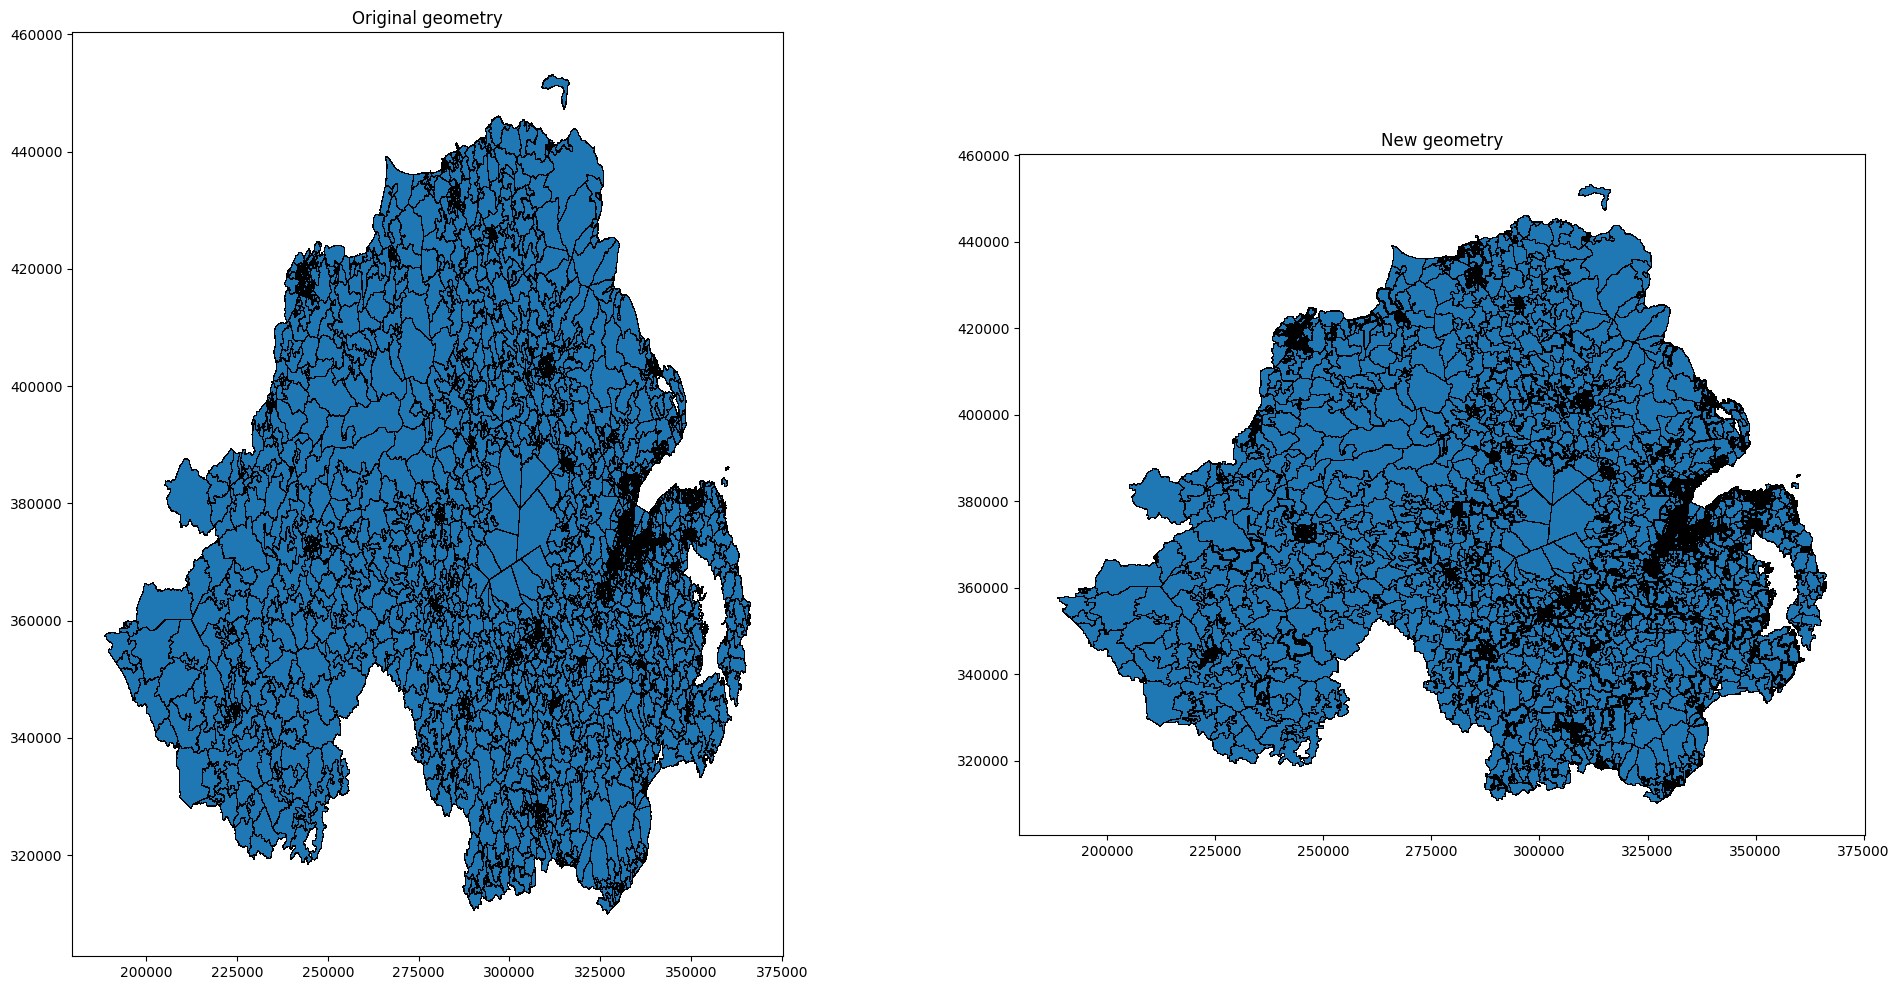

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

gdf_sa.plot(ax=axs[0], antialiased=False, edgecolor='k', linewidth=0.1)

gdf = gdf_sa.set_geometry('geometry_round').set_crs(crs, allow_override=True)
gdf.plot(ax=axs[1], antialiased=False, edgecolor='k', linewidth=0.1)

axs[0].set_title('Original geometry')
axs[1].set_title('New geometry')

plt.savefig('test2.png')
plt.show()

In [117]:
# Save to file:
gdf = gdf_sa.drop('geometry', axis='columns')
gdf = gdf.rename(columns={'geometry_round': 'geometry'})
gdf = gdf.set_geometry('geometry').set_crs(crs, allow_override=True)

gdf.to_file(f'sa2011_200mgrid.geojson')

This method has _somewhat_ worked. 
+ The saved reduced geojson is now around 6MB in size, but
+ Gaps have been introduced between the smaller areas of the grid.

Plot again but zoom in on part of Belfast:

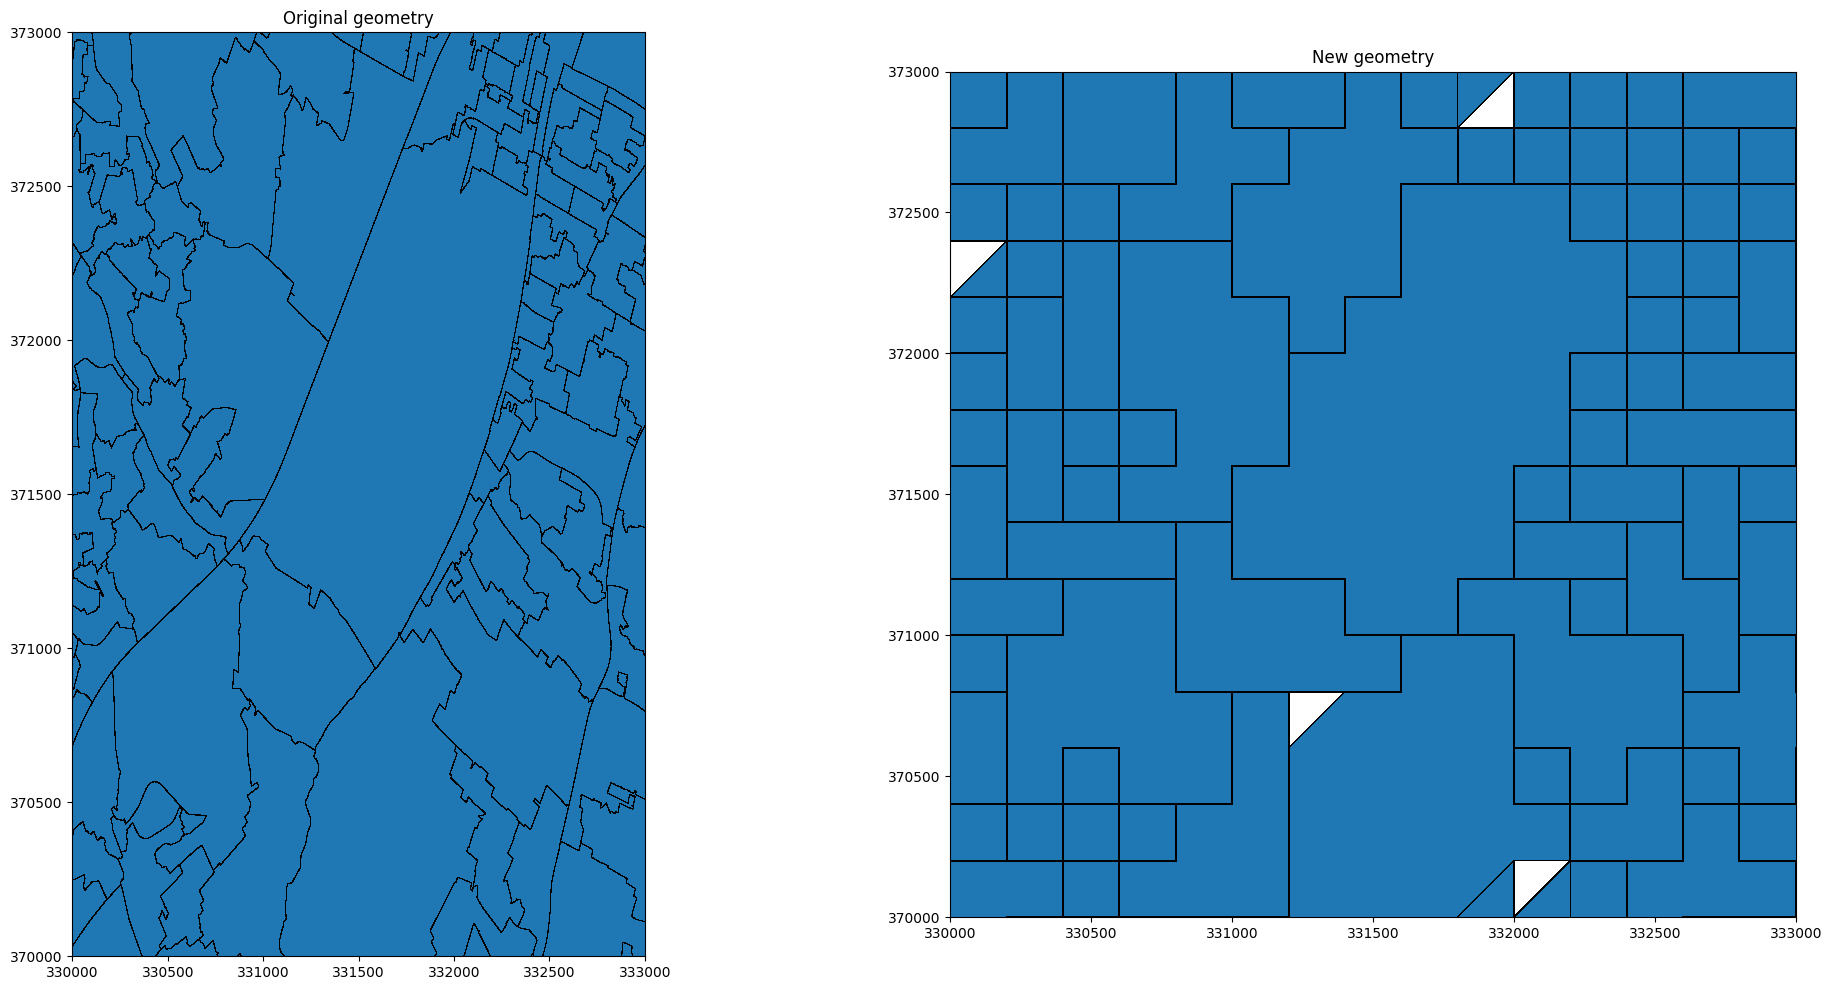

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

gdf_sa.plot(ax=axs[0], antialiased=False, edgecolor='k', linewidth=0.1)

gdf = gdf_sa.set_geometry('geometry_round').set_crs(crs, allow_override=True)
gdf.plot(ax=axs[1], antialiased=False, edgecolor='k', linewidth=0.1)

axs[0].set_title('Original geometry')
axs[1].set_title('New geometry')

for ax in axs:
    ax.set_xlim(330000, 333000)
    ax.set_ylim(370000, 373000)

plt.savefig('test2_zoom.png')
plt.show()

Repeat this process with a smaller grid size:

In [124]:
grid_size = 20

In [125]:
gdf_sa['geometry_round'] = shapely.set_precision(gdf_sa.geometry, grid_size=grid_size)

In [126]:
# Save to file:
gdf = gdf_sa.drop('geometry', axis='columns')
gdf = gdf.rename(columns={'geometry_round': 'geometry'})
gdf = gdf.set_geometry('geometry').set_crs(crs, allow_override=True)

gdf.to_file(f'sa2011_{grid_size}mgrid.geojson')

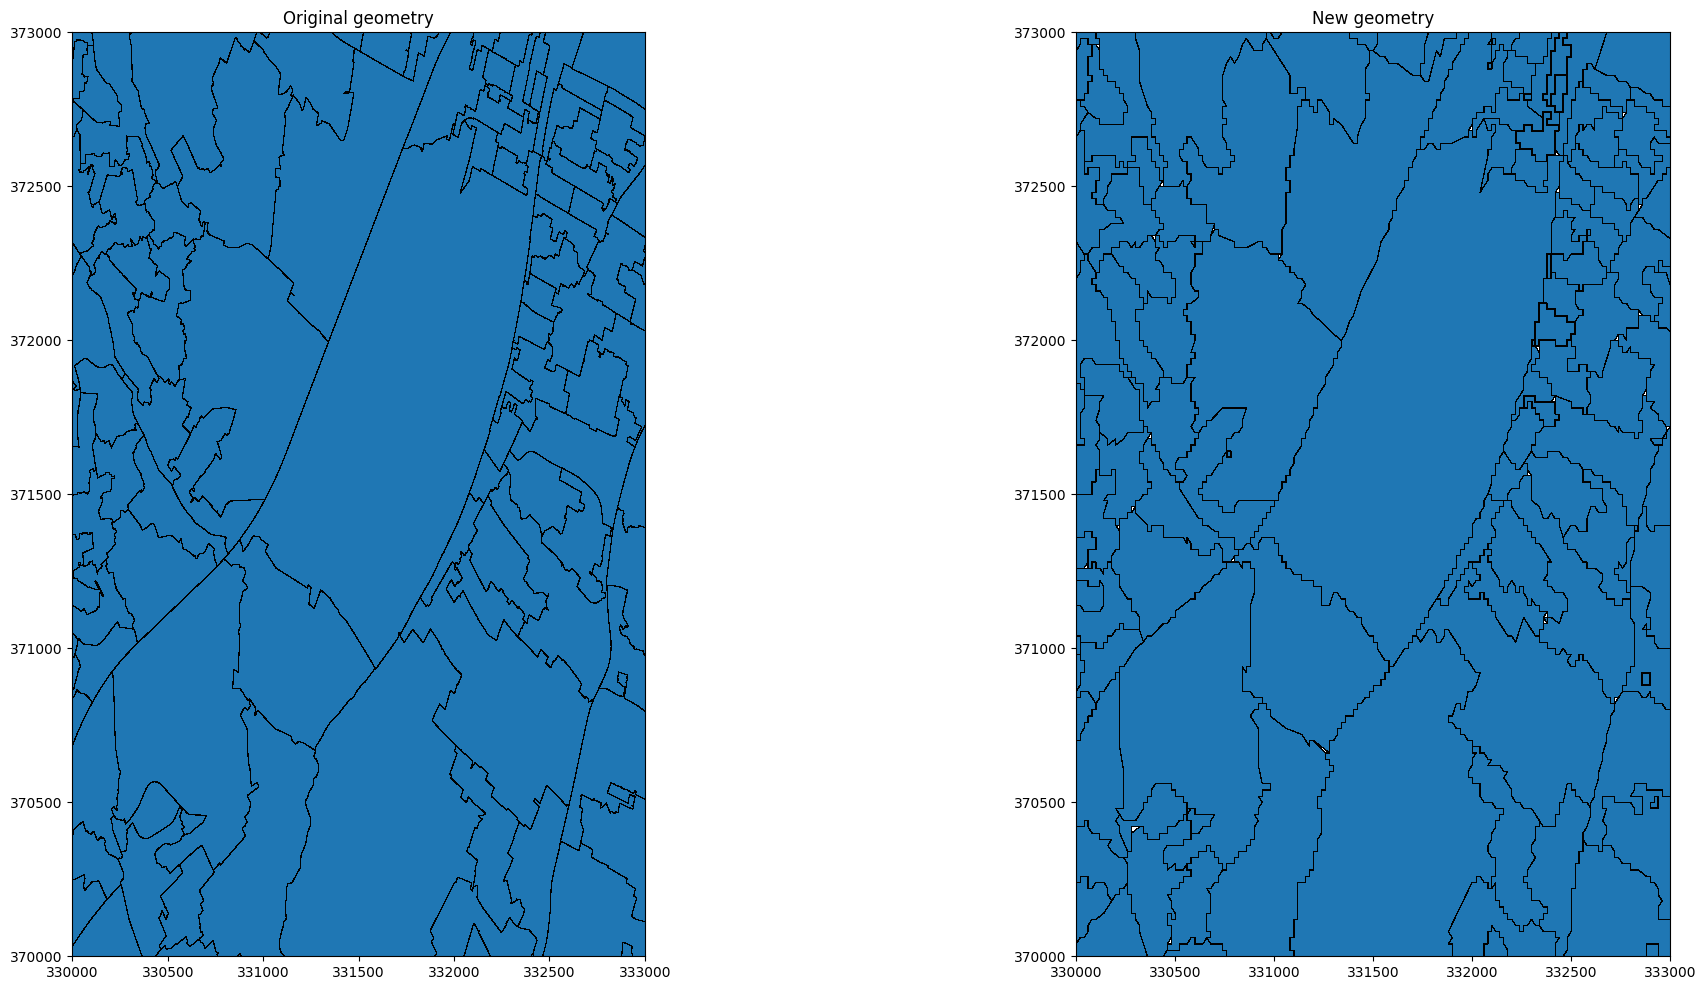

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

gdf_sa.plot(ax=axs[0], antialiased=False, edgecolor='k', linewidth=0.1)

gdf = gdf_sa.set_geometry('geometry_round').set_crs(crs, allow_override=True)
gdf.plot(ax=axs[1], antialiased=False, edgecolor='k', linewidth=0.1)

axs[0].set_title('Original geometry')
axs[1].set_title('New geometry')

for ax in axs:
    ax.set_xlim(330000, 333000)
    ax.set_ylim(370000, 373000)

plt.savefig(f'test2_{grid_size}m_zoom.png')
plt.show()

| Grid size | File size | Gaps? |
| --- | --- | --- |
| 200m | 5.6MB | Yes |
| 50m | 18.5MB | Yes |
| 20m | 39.1MB | Yes |

Ideally I don't want a file size above around 40MB, which is already pretty big. I suspect that this method will always create gaps between polygons unless such a high grid resolution is used that the file size is knocking on 100MB again.

Test status: fail.

Remove the new geometry from the starting data:

In [128]:
gdf_sa = gdf_sa.drop('geometry_round', axis='columns')

## Failed test 3: simplify polygons

In [164]:
simplify_level = 2.0

In [165]:
gdf_sa['geometry_simplify'] = gdf_sa['geometry'].simplify(simplify_level)

In [166]:
gdf_sa.head()

,OBJECTID,SA2011,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,Code_all,geometry,geometry_simplify
0,1,N00000002,95AA01S2,315465,377176,169.044,8476.858446,1.690436e+06,N00000002,"POLYGON ((315481.12500 376464.21880, 315472.34...","POLYGON ((315481.12500 376464.21880, 315463.06..."
1,2,N00000004,95AA01S2,307147,376182,8700.040,46727.719482,8.700042e+07,N00000004,"POLYGON ((307740.81250 382573.21880, 307762.25...","POLYGON ((307740.81250 382573.21880, 307762.25..."
2,3,N00000007,95AA01S3,314461,383440,1287.990,21817.292006,1.287995e+07,N00000007,"POLYGON ((311363.31250 385217.62500, 311600.00...","POLYGON ((311363.31250 385217.62500, 312800.00..."
3,4,N00000008,95AA01S3,317009,383798,343.431,13536.640411,3.434310e+06,N00000008,"POLYGON ((317103.21880 385406.96880, 317102.18...","POLYGON ((317103.21880 385406.96880, 317098.00..."
4,5,N00000009,95AA01S3,318697,383198,854.499,18169.764506,8.544992e+06,N00000009,"POLYGON ((317452.75000 385419.34380, 317458.68...","POLYGON ((317452.75000 385419.34380, 317473.50..."


In [167]:
# Save to file:
gdf = gdf_sa.drop('geometry', axis='columns')
gdf = gdf.rename(columns={'geometry_simplify': 'geometry'})
gdf = gdf.set_geometry('geometry').set_crs(crs, allow_override=True)

gdf.to_file(f'sa2011_level{simplify_level}'.replace(".", "!") + '.geojson')

Plot the old and new geometries for comparison:

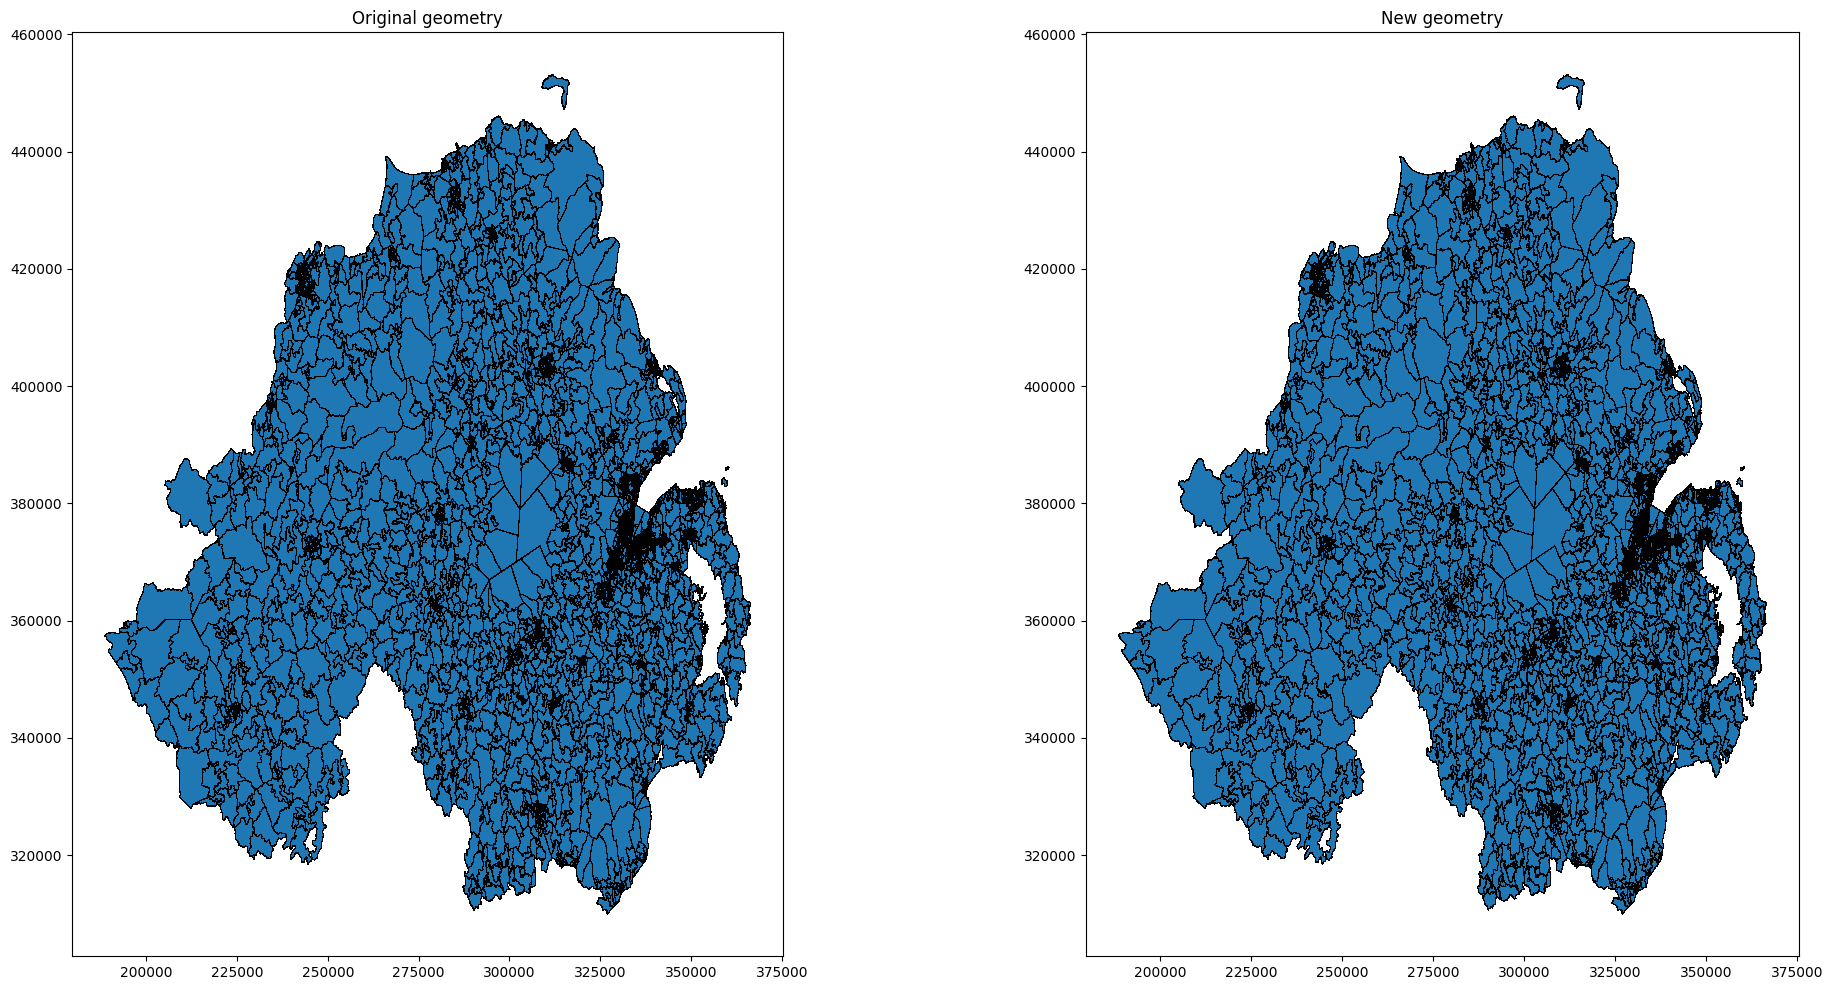

In [168]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

gdf_sa.plot(ax=axs[0], antialiased=False, edgecolor='k', linewidth=0.1)

gdf = gdf_sa.set_geometry('geometry_simplify').set_crs(crs, allow_override=True)
gdf.plot(ax=axs[1], antialiased=False, edgecolor='k', linewidth=0.1)

axs[0].set_title('Original geometry')
axs[1].set_title('New geometry')

plt.savefig(f'test3_level{simplify_level}'.replace(".", "!") + '.png')
plt.show()

| Simplify level | File size |
| --- | --- | --- | 
| 0.1 | 108MB |
| 0.5 | 59.9MB |
| 0.75 | 51.1MB |
| 1.0 | 45.6MB |
| 2.0 | 34.1MB |
| 5.0 | 22.7MB |
| 10.0 | 16.6MB |


Simplify level 10 gives noticeably tiny gaps between small polygons like in Belfast.

Simplify level 1 and even 0.5 has these gaps between long straight line edges of larger polygons. They're present but you have to really look to find any.

Would be better off simplifying adjacent polygons together rather than individually and hoping that identical changes are made.

## Test 4: mapshaper tool

Use the mapshaper website to simplify polygons.

Saved a copy simplified to 20% for the `stroke-maps` data and a copy simplified to 0.5% for the streamlit apps. 

+ [https://mapshaper.org/](https://mapshaper.org/)
+ Visvalingam / weighted area setting
+ Resulting file sizes 31.0MB and 3.5MB respectively

Success! No gaps.

In [169]:
gdf_simp = gpd.read_file('sa2011_simplify20perc.json')

In [170]:
gdf_simp.head()

,OBJECTID,SA2011,SOA2011,X_COORD,Y_COORD,Hectares,Shape_Leng,Shape_Area,Code_all,geometry
0,1,N00000002,95AA01S2,315465,377176,169.044,8476.858446,1.690436e+06,N00000002,"POLYGON ((315481.12500 376464.21880, 315524.03..."
1,2,N00000004,95AA01S2,307147,376182,8700.040,46727.719482,8.700042e+07,N00000004,"POLYGON ((307740.81250 382573.21880, 304077.31..."
2,3,N00000007,95AA01S3,314461,383440,1287.990,21817.292006,1.287995e+07,N00000007,"POLYGON ((311363.31250 385217.62500, 311325.09..."
3,4,N00000008,95AA01S3,317009,383798,343.431,13536.640411,3.434310e+06,N00000008,"POLYGON ((317103.21880 385406.96880, 317080.78..."
4,5,N00000009,95AA01S3,318697,383198,854.499,18169.764506,8.544992e+06,N00000009,"POLYGON ((317452.75000 385419.34380, 317410.56..."


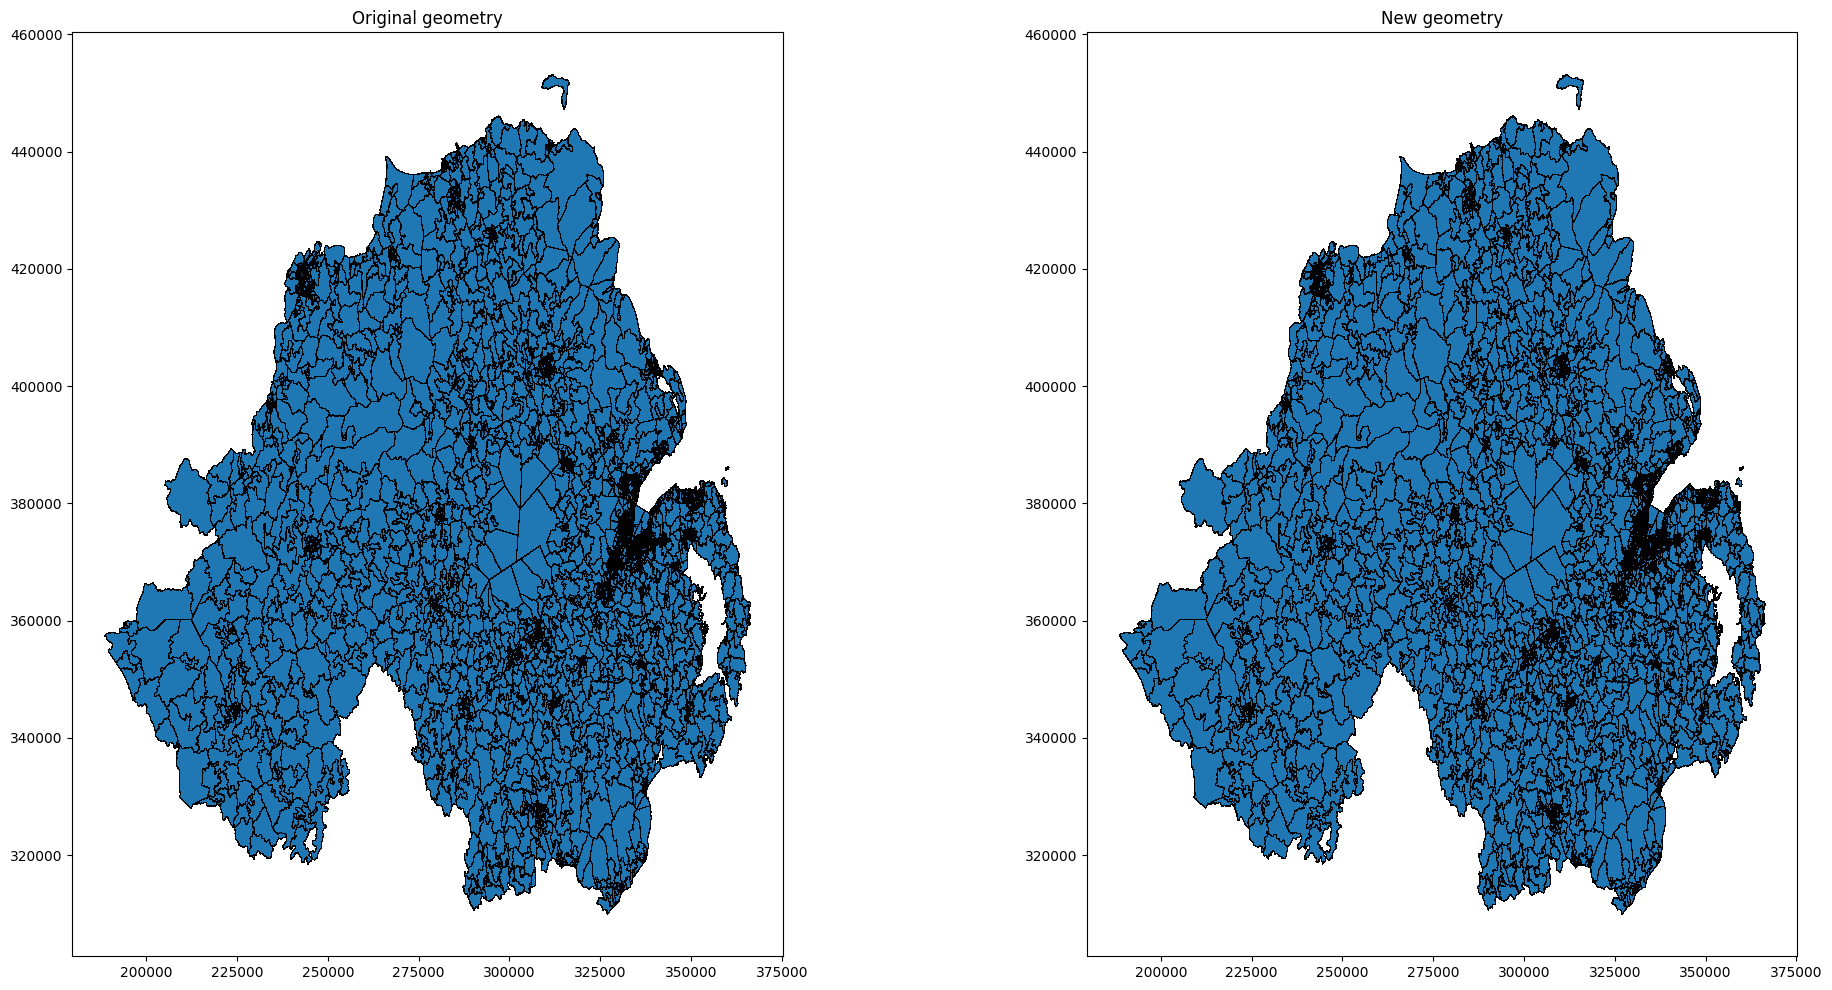

In [171]:
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

gdf_sa.plot(ax=axs[0], antialiased=False, edgecolor='k', linewidth=0.1)

# gdf = gdf_sa.set_geometry('geometry_simplify').set_crs(crs, allow_override=True)
gdf_simp.plot(ax=axs[1], antialiased=False, edgecolor='k', linewidth=0.1)

axs[0].set_title('Original geometry')
axs[1].set_title('New geometry')

plt.savefig(f'test4_20perc.png')
plt.show()